## Segunda parte

### **4. Extracción de etiquetas**

En el archivo [etiquetas.csv](https://drive.google.com/file/d/1LWY3VoIRt0xKwEbbtMXYePOGZvgPsQh-/view?usp=sharing) están las etiquetas para un pequeño subconjunto de nodos. Podemos interpretar el valor de la etiqueta como la pertenencia a una determinada clase, donde los usuarios de una misma clase en general tienden a expresar apoyo entre sí.

- Determinar quiénes son los usuarios referentes de cada clase (utilizar alguna medida de centralidad calculada sobre el grafo de retweets).
- Utiliando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades.

**Opcional:** Reconstruir el archivo "etiquetas.csv". Para eso, hacer lo siguiente

- Construir un grafo en donde los nodos sean usuarios, y donde los enlaces unan dos nodos si entre ellos hubo más respuestas de apoyo que de oposición.
- Extraer las dos componentes más grandes del grafo. Esos serán nuestros nodos etiquetados.

### **5. Embedding de nodos**

- Generar un embedding del grafo de retweets utilizando el algoritmo `word2vec`.
- Reducir a 2 la dimensionalidad del embedding utilizando [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).
- Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?

**Opcional:** Graficar además los embeddings de los nodos que forman parte de las comunidades asociadas a cada clase. Determinar si el embedding permite distinguir cada comunidad.

### **Opcional: 6. Redes neuronales de grafos**

El archivo [word_vectors.csv](https://drive.google.com/file/d/1aoxugyMktKb0NQ8Pf3bdhKvh8BAj7YZz/view?usp=sharing) contiene un embedding de 300 dimensiones para cada tweet, otenido utilizando un modelo preentrenado de [FastText](https://fasttext.cc/). Construir una matriz de features para los nodos tomando, para cada usuario, el promedio de los vectores correspondientes a los tweets que escribió. Utilizando estos features, y tomando como ejemplos etiquetados los usuarios de "etiquetas.csv" entrenar una red neuronal de grafos para realizar una clasificación binaria sobre el resto de los nodos. Pueden utilizar como base el siguiente modelo:

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Embedding final
        
        # Aplicamos un clasificador lineal sobre el embedding
        out = self.classifier(h)

        return out, h

**Observación:** para alimentar la red neuronal, es necesario construir un objeto de la clase `Dataset` de PyTorch-Geometric. Una forma de hacer eso es la siguiente

In [ ]:
from torch_geometric.data import InMemoryDataset, Data

## Reemplazar por el grafo correspondiente
g = nx.Graph()

## Etiquetas. Reemplazar por las clases del archivo 'etiquetas.csv'.
## Asignar la clase '2' a los ejemplos no etiquetados
labels = [1, 0, 2, ..., 1]

## True si el ejemplo está etiquetado (clases 0 y 1)
train_idx = [True, True, False, ..., True]

## Matriz de features (word vectors)
features = ...

adj = nx.to_scipy_sparse_matrix(g).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)


class TwitterDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(TwitterDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = g.number_of_nodes()
        
        # Features 
        data.x = torch.from_numpy(features).type(torch.float32)
        
        # Etiquetas
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2
        
        n_nodes = g.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[train_idx] = True
        data['train_mask'] = train_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

# DESARROLLO

### **4. Extracción de etiquetas**

En el archivo [etiquetas.csv](https://drive.google.com/file/d/1LWY3VoIRt0xKwEbbtMXYePOGZvgPsQh-/view?usp=sharing) están las etiquetas para un pequeño subconjunto de nodos. Podemos interpretar el valor de la etiqueta como la pertenencia a una determinada clase, donde los usuarios de una misma clase en general tienden a expresar apoyo entre sí.

- Determinar quiénes son los usuarios referentes de cada clase (utilizar alguna medida de centralidad calculada sobre el grafo de retweets).
- Utiliando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades.

**Opcional:** Reconstruir el archivo "etiquetas.csv". Para eso, hacer lo siguiente

- Construir un grafo en donde los nodos sean usuarios, y donde los enlaces unan dos nodos si entre ellos hubo más respuestas de apoyo que de oposición.
- Extraer las dos componentes más grandes del grafo. Esos serán nuestros nodos etiquetados.


In [21]:
import pandas as pd

df_info=pd.read_csv('../data/etiquetas.csv')
print(df_info.shape)
df_info.head(6)

(196, 2)


,user.id,Clase
0,1227432088925851650,0
1,1148843472,0
2,1329815581302853632,0
3,131669966,0
4,811607948,0
5,405924380,0


Cargamos el dataset con las metricas de centralidad

In [15]:
df_centralidad=pd.read_csv('../data/df_centralidad.csv')
print(df_centralidad.shape)
df_centralidad.head(3)

(38998, 7)


,nodo,degree,betweenness_centrality,eigenvector_centrality,closeness_centrality,pagerank,transitividad
0,2258074658,19,0.000172,0.003449,0.286305,0.000070,0.052632
1,2737379453,9,0.000103,0.000283,0.244898,0.000039,0.000000
2,159909978,1,0.000000,0.000003,0.196722,0.000007,0.000000


In [22]:
df=df_centralidad.merge(df_info,left_on='nodo',right_on='user.id')
print(df.shape)

(152, 9)


Existen 44 usuarios que no estan en el dataset porque nos hemos quedaod con la componente gigante

<b> Usuarios referentes de cada clase

In [29]:
print('Nodos mas importantes clase 0:')
df[df.Clase==0][['nodo','degree','eigenvector_centrality','Clase']].sort_values(['degree','eigenvector_centrality'],ascending=False).nodo[:10]

Nodos mas importantes clase 0:


1                252168075
27               510740590
48               145493922
28               484349869
106    1272713534078619648
117               43814969
69     1092059695383281666
66               145010134
37               405924380
31                35961319
Name: nodo, dtype: int64

In [30]:
print('Nodos mas importantes clase 1:')
df[df.Clase==1][['nodo','degree','eigenvector_centrality','Clase']].sort_values(['degree','eigenvector_centrality'],ascending=False).nodo[:10]

Nodos mas importantes clase 1:


3                73102744
6               367933714
9              2687724840
4              3421061763
10             4160782817
22    1146448109070966784
89    1014284625592639489
43     837186873143488514
24              206371045
14    1172610671965548545
Name: nodo, dtype: int64

In [31]:
from cdlib import NodeClustering, evaluation, algorithms

comms = algorithms.louvain(G, weight='weight', resolution=1, randomize=False)

In [36]:
print('Se han encontrado {} comunidades '.format(len(comms.communities)))

Se han encontrado 49 comunidades 


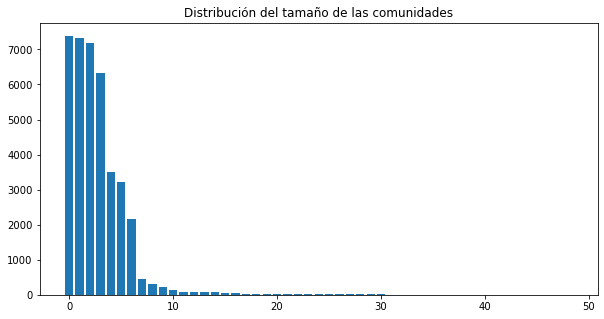

In [38]:
len_comunidades=[]

for community in comms.communities:
    len_comunidades.append(len(community))

plt.figure(figsize=(10,5))
plt.bar(height=len_comunidades,x=np.arange(49))
plt.title("Distribución del tamaño de las comunidades")
plt.show()

In [71]:
usuarios=[]
comunidades=[]

for usuario in df.nodo.unique():
    for comunidad in comms.communities:
        if str(usuario) in comunidad:
            usuarios.append(usuario)
            comunidades.append(comms.communities.index(comunidad))


df_usuarios_comunidad=pd.DataFrame({'usuario:':usuarios,'comunidad':comunidades,'clase':df.Clase.tolist()})



In [83]:
df_usuarios_comunidad.groupby('clase')['comunidad'].nunique().reset_index()

,clase,comunidad
0,0,2
1,1,6


Como se puede ver, en la totalidad de usuarios de la clase 1 hay 2 comunidades diferentes asignadas por el metodo de Louvain, mientras que en la clase 2 hay 6.